# Machine Learning - Exercise 3

We continue Andrew Ng's course with Multi-class classification and introduction to Neural Networks. 

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as snsimg
%matplotlib inline
import scipy.optimize as op
from scipy.io import loadmat

## Problem 1: Multi-Class Classification

Will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). We can use our same code for log regression from the last post to run one-vs-all method

### Problem 1.1: Loading the Dataset

We are given a .mat dataset, so we need to do something different this time to read this data. With some help of Stackoverflow and Kaggle, I found a method to load this data easily

In [19]:
data = loadmat('./data/ex3data1.mat')
X, y = data["X"], data["y"].ravel()

There are 5000 traning examples in this training set, each one with 20x20 pixel greyscale image of a number

In [3]:
print(np.shape(X))

(5000, 400)


And from those 5000 training examples, the y vector contains the labels of each one. From 1-10 (with 10 being 0). 500 samples training samples from each

In [5]:
print(np.unique(y))
print(np.bincount(y)[1:])

[ 1  2  3  4  5  6  7  8  9 10]
[500 500 500 500 500 500 500 500 500 500]


### Problem 1.2: Visualizing the Data

First, we will come up with a function using plt.imshow to show a plot of the first value of X 20x20 pixel image

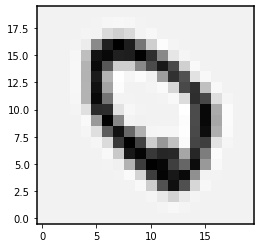

In [9]:
plt.imshow(X[0,:].reshape((20, 20)).T, cmap=plt.cm.binary, interpolation='nearest')

Then, we will print the label in y to check if our code is correct.

In [10]:
print(y[0])

10


Now, we can randomly select 1000 rows and print them as an example, knowing our code is correct

Randomly select 100 rows from X. This function (plt.imshow) maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together

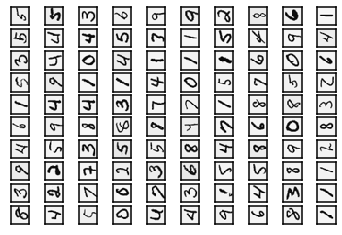

In [21]:
plt.figure()
rng = np.random.RandomState(0)
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(X[rng.randint(X.shape[0])].reshape((20, 20)),
               cmap=plt.cm.binary, interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.show()

### Problem 1.3: Vectorizing Log Reg

Now, we will be using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, will need to train 10 separate logistic regression classifier (1-10)

In [9]:
def sigmoid(z):
    g = 1/(1+np.exp(-z))
    return g

In [10]:
def lrCostFun(theta, X, y, lam):
    h = sigmoid(np.dot(X,theta))
    t = np.zeros(len(theta))
    t[1:] = theta[1:]
    J = ((np.dot(y,np.log(h))+np.dot((1-y),np.log(1-h)))/-len(X))+((np.dot(t,t))*lam/(2*len(X)))
    grad = (np.dot(X.T,(h-y))/len(X))+((t*lam)/len(X))
    return J, grad

In [11]:
theta_t = np.array([-2, -1, 1, 2])
X_t = np.array([[1., 0.1, 0.6, 1.1],
                [1., 0.2, 0.7, 1.2],
                [1., 0.3, 0.8, 1.3],
                [1., 0.4, 0.9, 1.4],
                [1., 0.5, 1.0, 1.5]])
y_t = np.array([1, 0, 1, 0, 1])
lambda_t = 3

In [12]:
J, grad = lrCostFun(theta_t,X_t,y_t,lambda_t)
print(J)
print(grad)

2.5348193961097443
[ 0.14656137 -0.54855841  0.72472227  1.39800296]


### Problem 1.4: One vs all classification

Now, we need to build a function to calculate all theta for each of k=10 classifiers

In [13]:
def cost(theta, X, y, lam):
    h = sigmoid(np.dot(X,theta))
    t = np.zeros(len(theta))
    t[1:] = theta[1:]
    J = ((np.dot(y,np.log(h))+np.dot((1-y),np.log(1-h)))/-len(X))+((np.dot(t,t))*lam/(2*len(X)))
    return J

def gradient(theta, X, y, lam):
    h = sigmoid(np.dot(X,theta))
    t = np.zeros(len(theta))
    t[1:] = theta[1:]
    grad = (np.dot(X.T,(h-y))/len(X))+((t*lam)/len(X))
    return grad

In [14]:
def oneVsAll(X, y, num_labels, lam):
    X_train = np.hstack((np.ones((X.shape[0], 1)), X))
    all_theta = np.zeros((num_labels, X_train.shape[1]))
    for i in range(1, num_labels + 1):
        y_train = (y == i).astype(int)
        initial_theta = np.zeros(X_train.shape[1])
        res = op.minimize(fun=cost, x0=initial_theta,
                                args=(X_train, y_train, lam),method='CG', jac=gradient)
        all_theta[i - 1] = res.x
    return all_theta

In [15]:
lam = 0.1
num_labels = 10
all_theta = oneVsAll(X, y, num_labels, lam)

In [16]:
np.shape(all_theta)

(10, 401)

In [17]:
def predictOneVsAll(all_theta, X):
    X_train = np.hstack((np.ones((X.shape[0], 1)), X))
    prob = np.dot(X_train, all_theta.T)
    pred = np.argmax(prob, axis=1) + 1
    return pred

In [18]:
predict= np.mean(predictOneVsAll(all_theta, X)==y)
print("Percentage prediction for training set =",predict*100, "%")

Percentage prediction for training set = 96.41999999999999 %


Finally, to see if it is working, lets predict one value, using as example y[0]=10 we already showed above

Neural Network Prediction: [10] digit [0]


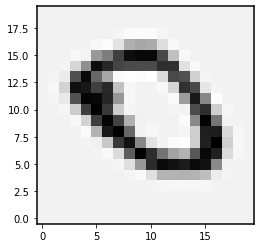

In [58]:
X_test = X[0,:].reshape(1,len(X[0,:]))
pred = predictOneVsAll(all_theta, X_test)
print('Neural Network Prediction:', pred, 'digit',(pred%10))
plt.imshow(X_test.reshape((20, 20)), cmap=plt.cm.binary, interpolation='nearest')

Also from just looking, I saw one of the mistakes, last row had a label y[-1] = 9, but the model predicted a 7

In [20]:
print('Predicted Value',predictOneVsAll(all_theta, X)[-1])
print('Actual Value',y[-1])

Predicted Value 7
Actual Value 9


## Problem 2: Neural Networks

We will be using parameters from a neural network that we have already trained. Our goal is to implement the feedforward propagation algorithm to use our weights for prediction.

### Problem 2.1: Model Representation

In [21]:
w = loadmat('./data/ex3weights.mat')
theta1, theta2 = w["Theta1"], w["Theta2"]

In [22]:
def sigmoid(z):
    g = 1/(1+np.exp(-z))
    return g

In [23]:
print(X.shape)
print(theta1.shape)
print(theta2.shape)

(5000, 400)
(25, 401)
(10, 26)


In [24]:
def predict(theta1, theta2, X):
    X_train = np.hstack((np.ones((X.shape[0], 1)), X))
    a2 = sigmoid(np.dot(X_train,theta1.T))
    a2_train = np.hstack((np.ones((a2.shape[0], 1)), a2))
    prob = sigmoid(np.dot(a2_train,theta2.T))
    pred = np.argmax(prob, axis=1) + 1
    return pred

In [25]:
pred = np.mean(predict(theta1,theta2,X)==y)
print("Percentage prediction for training set using NN =",pred*100, "%")

Percentage prediction for training set using NN = 97.52 %


Now, we can see that our % increased and the last label in our train data set got the correct prediction

Predicted Value 9
Actual Value 9


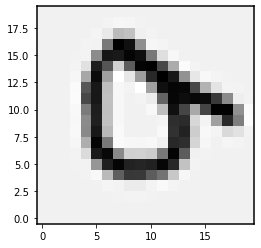

In [27]:
plt.imshow(X[-1,:].reshape((20, 20)), cmap=plt.cm.binary, interpolation='nearest')
print('Predicted Value',predict(theta1,theta2,X)[-1])
print('Actual Value',y[-1])

Neural Network Prediction: [5] digit [5]


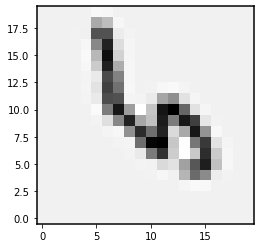

In [48]:
rng = np.random.RandomState(0)
X_rand = X[rng.randint(X.shape[0])]
X_test = X_rand.reshape(1,len(X_rand))
pred = predict(theta1, theta2, X_test)
print('Neural Network Prediction:', pred, 'digit',(pred%10))
plt.imshow(X_rand.reshape((20, 20)), cmap=plt.cm.binary, interpolation='nearest')